In [1]:
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from xgcm import Grid
import dask.array as da

from scipy.signal import savgol_filter

from modes_func import *
from definition.defPrincipal import *

In [2]:
def adjust_grid(ds):
        # relevant to regular/analytical grid for now
        #
        ds = ds.reset_coords([c for c in ds.coords if 'nav' in c])
        
        # rename redundant dimensions
        _dims = (d for d in ['x_v', 'y_u', 'x_w', 'y_w'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: d[0]+'_rho'})
                
        # change nav variables to coordinates        
        _coords = [d for d in [d for d in ds.data_vars.keys()] if "nav_" in d]
        ds = ds.set_coords(_coords) 
        
        # rename coordinates 
        eta_suff={}
        for c in ds.coords:
            new_c = c.replace('nav_lat','eta').replace('nav_lon','xi')
            ds = ds.rename({c:new_c})
            # reset names and units
            ds[new_c] = (ds[new_c].assign_attrs(units='m', 
                                               standard_name=new_c,
                                               long_name=new_c)
                        )
        return ds
    

def addGrille(ds):
    # On récupère la liste des fichiers à ouvrir via le fichier liste 
    path = "../"
    gridname = path+'gigatl3_grid.nc'
    gridname = path+'GIGATL6_12h_inst_2004-01-15-2004-01-19.nc'
    gd = xr.open_dataset(gridname, chunks={'s_rho': 1})
    ds['hc'] = gd.hc
    ds['h'] = gd.h
    # ds['Vtransform'] = gd.Vtransform
    ds['sc_r'] = gd.sc_r
    ds['sc_w'] = gd.sc_w
    ds['Cs_r'] = gd.Cs_r
    ds['Cs_w'] = gd.Cs_w
    ds['angle'] = gd.angle
    ds['mask_rho'] = gd.mask_rho

    # On modifie des dimensions et des coordonnées, on crée la grille xgcm
    ds = adjust_grid(ds)
    L = ds.dims['x_rho']
    M = ds.dims['y_rho']
    N = ds.dims['s_rho']

    # On crée la grille xgcm
    ds = xgcm_grid(ds)
    grid = ds.attrs['xgcm-Grid']
    return ds, grid

    
def xgcm_grid(ds):
        # Create xgcm grid
        coords={'xi':{'center':'x_rho', 'inner':'x_u'}, 
                'eta':{'center':'y_rho', 'inner':'y_v'}, 
                's':{'center':'s_rho', 'outer':'s_w'}}
        ds.attrs['xgcm-Grid'] = Grid(ds, coords=coords)
        
        return ds

In [3]:
exp = 'bvf_GIGATL6'
indir = '../'
infile = indir+exp+'.nc'
ds = xr.open_dataset(infile)
# data = data.sel(x_rho = slice(-40,-20), y_rho = slice(-2.5,2.5))
# data = data.sel(time=slice("2009-10-01","2010-07-01"))

dsZeta = xr.open_dataset('../zeta_GIGATL6.nc')
# ds['zeta'] = dsZeta.zeta.values
ds, grid = addGrille(ds)
dsZeta, grid = addGrille(dsZeta)
ds['Vtransform'] = 2

# dsZeta = dsZeta.isel(time_counter = 0, x_rho = slice(0,None,2), y_rho = slice(0,None,2))
# ds = ds.isel(time_counter = 0, x_rho = slice(0,None,2), y_rho = slice(0,None,2))

In [4]:
ds['Vtransform'] = 2
dsZeta

<xarray.Dataset>
Dimensions:   (s_rho: 50, s_w: 51, x_rho: 1502, y_rho: 2002)
Coordinates:
    eta_rho   (y_rho, x_rho) float32 ...
    xi_rho    (y_rho, x_rho) float32 ...
  * s_rho     (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.05 -0.03 -0.01
  * s_w       (s_w) float32 -1.0 -0.98 -0.96 -0.94 ... -0.06 -0.04 -0.02 0.0
Dimensions without coordinates: x_rho, y_rho
Data variables:
    zeta      (y_rho, x_rho) float32 ...
    hc        float32 ...
    h         (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
    sc_r      (s_rho) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    sc_w      (s_w) float32 dask.array<chunksize=(51,), meta=np.ndarray>
    Cs_r      (s_rho) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    Cs_w      (s_w) float32 dask.array<chunksize=(51,), meta=np.ndarray>
    angle     (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
    mask_rho  (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
Attributes:
    xgcm-Grid:  <xgcm.Grid>\nxi Axis (periodic, boundary=None):\n  * center  ...

In [5]:
%%time
# Compute depth at rho point
z = get_z(ds,zeta=dsZeta['zeta'],hgrid='r').compute()

CPU times: user 3.1 s, sys: 6.98 s, total: 10.1 s
Wall time: 9.95 s


In [6]:
bvf=w2rho(ds.bvf,ds)
bvf

<xarray.DataArray 'bvf' (s_rho: 50, y_rho: 2002, x_rho: 1502)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * s_rho    (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.07 -0.05 -0.03 -0.01
    eta_w    (y_rho, x_rho) float32 ...
    xi_w     (y_rho, x_rho) float32 ...
    eta_rho  (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
    xi_rho   (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
Dimensions without coordinates: y_rho, x_rho

In [7]:
# %%time
# #plot slice longitude
# longitude = -23.
# vnew= slice2(ds,bvf,z,longitude=longitude)

CPU times: user 904 ms, sys: 122 ms, total: 1.03 s
Wall time: 1.6 s


In [8]:
%%time
#plot slice latitude
latitude = 0.
vnew= slice2(ds,bvf,z, latitude=latitude)

CPU times: user 775 ms, sys: 29 ms, total: 804 ms
Wall time: 814 ms


In [9]:
yrho, xrho = findLatLonIndex(ds, -20.,0.)
print(xrho)

915


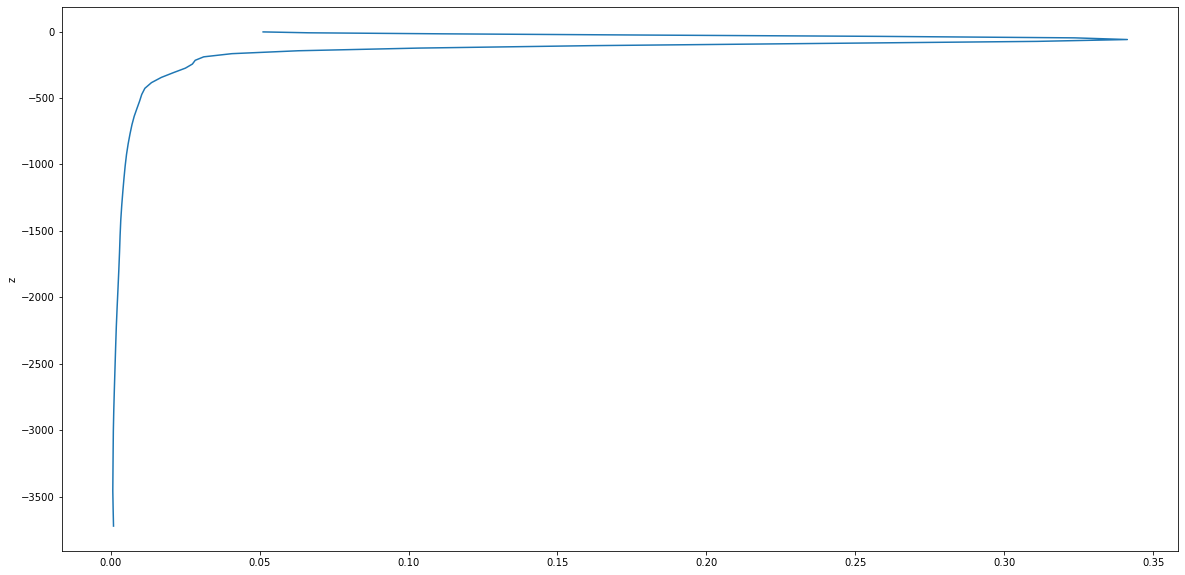

In [16]:
plt.figure(figsize=(20,10))

vnew2=vnew.isel(x_rho=xrho)*1e3

zzz = z.isel(y_rho = yrho, x_rho=xrho)
vnew2.plot(y='z')

In [11]:
ds = xr.open_dataset(infile)

In [12]:
ds.isel(x_w = 915 , y_w = 776)

<xarray.Dataset>
Dimensions:    (s_w: 51)
Coordinates:
  * s_w        (s_w) float32 -1.0 -0.98 -0.96 -0.94 ... -0.06 -0.04 -0.02 0.0
    nav_lat_w  float32 ...
    nav_lon_w  float32 ...
Data variables:
    bvf        (s_w) float32 ...

In [14]:
z.isel(y_rho = yrho, x_rho=xrho)

<xarray.DataArray 'z_r' (s_rho: 50)>
array([-3.71835207e+03, -3.59099040e+03, -3.45420805e+03, -3.30960231e+03,
       -3.15890273e+03, -3.00388748e+03, -2.84631012e+03, -2.68783870e+03,
       -2.53001095e+03, -2.37420161e+03, -2.22160328e+03, -2.07321994e+03,
       -1.92986733e+03, -1.79218120e+03, -1.66063109e+03, -1.53553593e+03,
       -1.41708195e+03, -1.30534176e+03, -1.20029162e+03, -1.10182913e+03,
       -1.00978870e+03, -9.23956020e+02, -8.44080120e+02, -7.69884431e+02,
       -7.01075975e+02, -6.37352736e+02, -5.78410188e+02, -5.23946339e+02,
       -4.73665557e+02, -4.27281769e+02, -3.84520748e+02, -3.45121749e+02,
       -3.08838605e+02, -2.75440465e+02, -2.44712064e+02, -2.16453866e+02,
       -1.90481915e+02, -1.66627489e+02, -1.44736792e+02, -1.24670452e+02,
       -1.06303014e+02, -8.95224313e+01, -7.42295493e+01, -6.03376100e+01,
       -4.77717946e+01, -3.64687894e+01, -2.63764265e+01, -1.74533637e+01,
       -9.66882156e+00, -3.00239231e+00])
Coordinates:
    eta_rho  float32 -0.008676
    xi_rho   float32 -20.02
    eta_w    float32 -0.008676
    xi_w     float32 -20.02
  * s_rho    (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.07 -0.05 -0.03 -0.01

In [18]:
vnew2.z.values

array([-3.72145805e+03, -3.59398677e+03, -3.45708634e+03, -3.31235549e+03,
       -3.16152535e+03, -3.00637567e+03, -2.84866155e+03, -2.69005259e+03,
       -2.53208790e+03, -2.37614339e+03, -2.22341281e+03, -2.07490098e+03,
       -1.93142440e+03, -1.79361937e+03, -1.66195589e+03, -1.53675312e+03,
       -1.41819752e+03, -1.30636170e+03, -1.20122197e+03, -1.10267579e+03,
       -1.01055744e+03, -9.24652386e+02, -8.44709461e+02, -7.70451850e+02,
       -7.01586299e+02, -6.37810540e+02, -5.78819753e+02, -5.24311682e+02,
       -4.73990435e+02, -4.27569679e+02, -3.84774934e+02, -3.45345233e+02,
       -3.09034185e+02, -2.75610727e+02, -2.44859402e+02, -2.16580497e+02,
       -1.90589889e+02, -1.66718707e+02, -1.44813018e+02, -1.24733319e+02,
       -1.06354050e+02, -8.95630580e+01, -7.42611015e+01, -6.03613450e+01,
       -4.77889023e+01, -3.64804029e+01, -2.63836319e+01, -1.74572101e+01,
       -9.67033056e+00, -3.00256706e+00])